## Application of causal discovery and causal inference methods to climate dynamics problem
##### Here, this notebook shows and explains step by step a causal approach to analyse linkages among ENSO, circulation fields, and summer monsoon precipitation over the Himalayas.

In [13]:
from warnings import filterwarnings
filterwarnings("ignore")

from src.DataProcessingClass import DataProcessingClass
from src.CausalityClass import CausalityClass

#### Preprocessing of climate indices (or time series data): 
#### ENSO - El Niño–Southern Oscillation
#### WC - Walker cell
#### MHC - Monsoon Hadley cell
#### Himalayan precipitation

In [14]:
# Create a class instance for data preprocessing
dpc = DataProcessingClass()

# Load climate indices from netCDF files.
D = dpc.load_netcdf_files()

Input dir path: data/
Selected indices:  ['enso', 'mhc', 'precip', 'wc']
0 enso.nc
1 mhc.nc
2 precip.nc
3 wc.nc


In [15]:
D['wc'].wc.values = D['wc'].wc.values * -1.0

#### Plot the location of the WC/HP and MHC indices

da <xarray.Dataset>
Dimensions:    (time: 1, latitude: 221, longitude: 361)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... -4.5 -4.75 -5.0
  * longitude  (longitude) float32 45.0 45.25 45.5 45.75 ... 134.5 134.8 135.0
Data variables:
    orog       (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.5


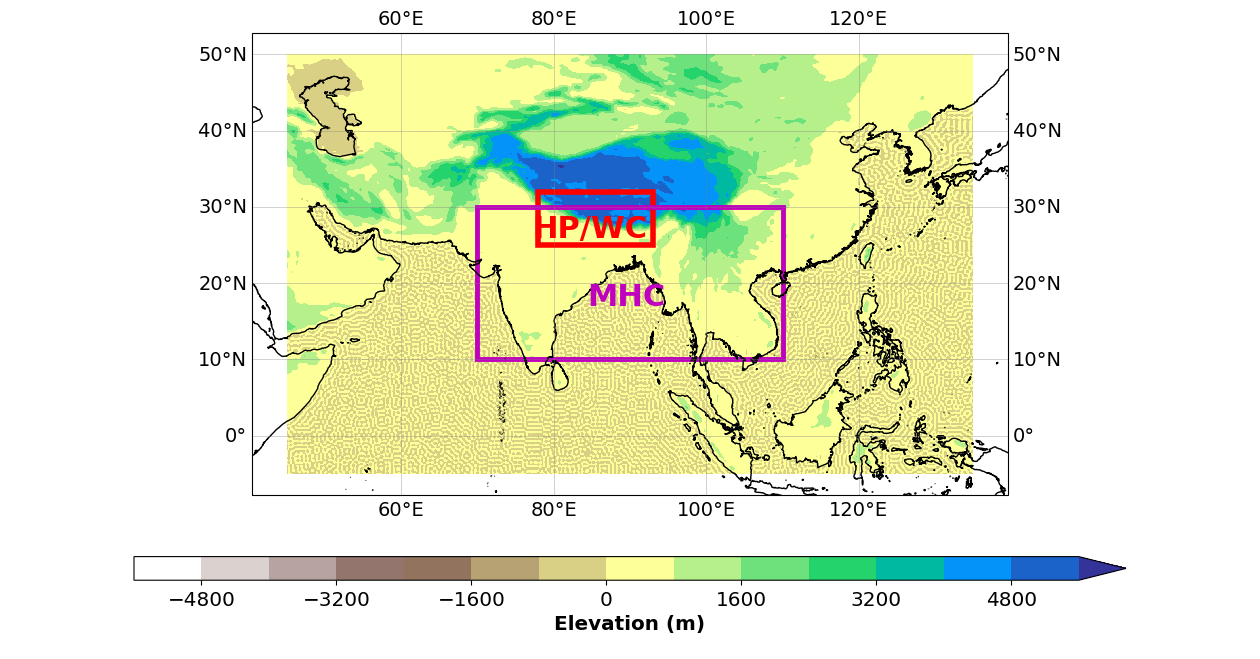

In [16]:
dpc.plot_indices_over_orography()

#### Transfrom precipitation data with logarithmic function

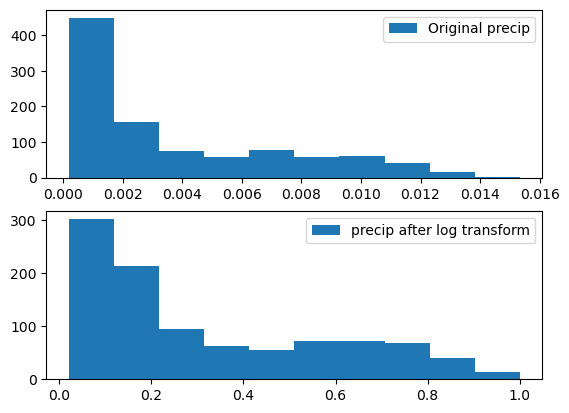

In [17]:
# Apply log transform
dpc.transform_precip(D, ind_name='precip', apply_transform=True)

#### Apply ADF and KPSS statistical tests to indices to check for the stationarity 

In [18]:
# Use the Augmented Dickey-Fuller unit root test and Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
dpc.adf_kpss_tests(D)

Index: enso
Significance level: 0.05
ADF test: test statistics; p-value:  -7.065785772885115 5.085032990994129e-10
KPSS test: test statistics; p-value:  0.07138192512351936 0.1
Yes, the index is stationary.

Index: mhc
Significance level: 0.05
ADF test: test statistics; p-value:  -6.764301743988442 2.7418971521246714e-09
KPSS test: test statistics; p-value:  0.20256524111057098 0.1
Yes, the index is stationary.

Index: precip
Significance level: 0.05
ADF test: test statistics; p-value:  -5.087714502108937 1.483873363800904e-05
KPSS test: test statistics; p-value:  0.2821750549338365 0.1
Yes, the index is stationary.

Index: wc
No, the index is not stationary.



#### 1) Based on the result of statitiscal test perform detrending of WC index
#### 2) Remove climatological and seasonal cycles
#### 3) Normalise indices to a common range
#### 4) Select datapoint from climate indices from a specified timeframe of our interest

In [19]:
# Select index
ind_name = 'wc'

dpc.detrend_index(D, ind_name)

# Remove means
dpc.remove_means(D)

# Apply min max normalisation
dpc.min_max_norm(D)

# Select datapoint for May-September from each year for 1940-2022
dpc.select_datapoints(D)


#### Calculate lagged cross-correlations for all pairs of climate indices

In [20]:
# Choose max lag time
n_lags = -2

dpc.test_pairs_lag_corr(D, n_lags)

Pair: enso-->mhc
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.16745723919992023, pvalue=0.000614141046376721)
-1 PearsonRResult(statistic=-0.1222119742054426, pvalue=0.012829700722352795)
-2 PearsonRResult(statistic=0.0393378912173375, pvalue=0.4252616733350374)


Pair: enso-->precip
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.12025727692182964, pvalue=0.014232547925402414)
-1 PearsonRResult(statistic=-0.1513678594610773, pvalue=0.002012496404817756)
-2 PearsonRResult(statistic=0.023379627040393945, pvalue=0.6356747156730398)


Pair: enso-->wc
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.16268288661276922, pvalue=0.0008800991587990262)
-1 PearsonRResult(statistic=-0.13397712202940268, pvalue=0.006331368589467839)
-2 PearsonRResult(statistic=-0.02953528058266013, pvalue=0.5494802017705245)


Pair: mhc-->enso
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0

#### Build a causal graph using PCMCI algorithm.

Input Indices: (415, 2)
Dataframe size: (415, 2)

## Significant links at alpha = 0.05:

    Variable precip has 2 link(s):
        (wc -1): pval = 0.00000 | qval = 0.00000 | val =  0.249
        (precip -1): pval = 0.00000 | qval = 0.00000 | val = -0.242

    Variable wc has 1 link(s):
        (precip -1): pval = 0.00535 | qval = 0.00713 | val =  0.137


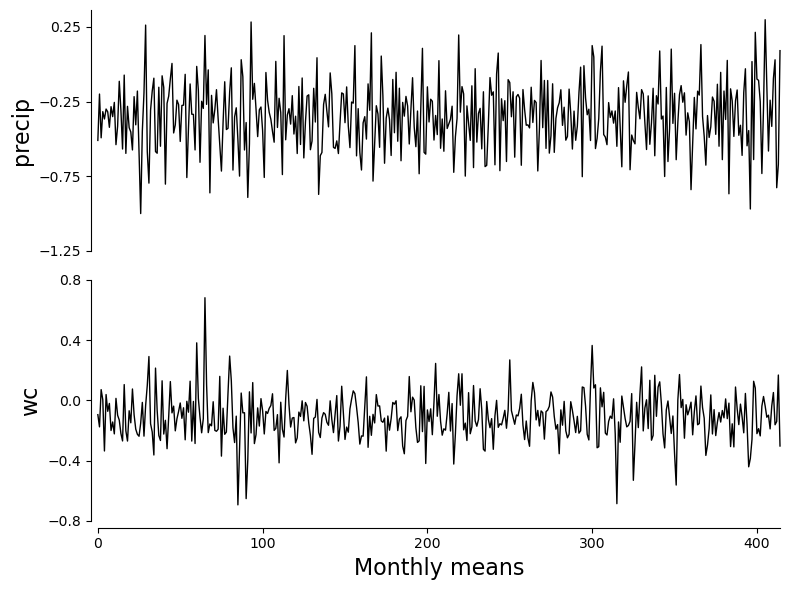

In [21]:
# Create a class instance with climate indices
ca = CausalityClass(D)

# subselect dict
from operator import itemgetter
ca.var_names = ['precip', 'wc']
D = dict(zip(ca.var_names, itemgetter(*ca.var_names)(D)))

# Construct a custom dataframe format used by Tigramite package
dataframe, var_names = ca.generate_dataframe(D) 

ca.plot_time_series(dataframe)

# Build the causal graph with PCMCI algorithm
sig_causal_parents = ca.construct_causal_graph(dataframe)

#### Use linear estimator to compute beta coefficients on the build causal graph

In [22]:
# Fit the linear estimator
val_matrix, link_matrix = ca.linear_estimator(sig_causal_parents, dataframe)

# Get the beta coefficients for the causal graph
ca.get_links_beta_coeffs()


### Beta coefficients for:

0 precip
1 wc
             0         1
1 -1  0.333648  0.000000
0 -1 -0.211337  0.074934


In [23]:
ca.linear_mediator.get_coefs()

{0: {(1, -1): 0.33364758, (0, -1): -0.21133672}, 1: {(0, -1): 0.07493434}}

#### Plot the causal graph a causal effect network 

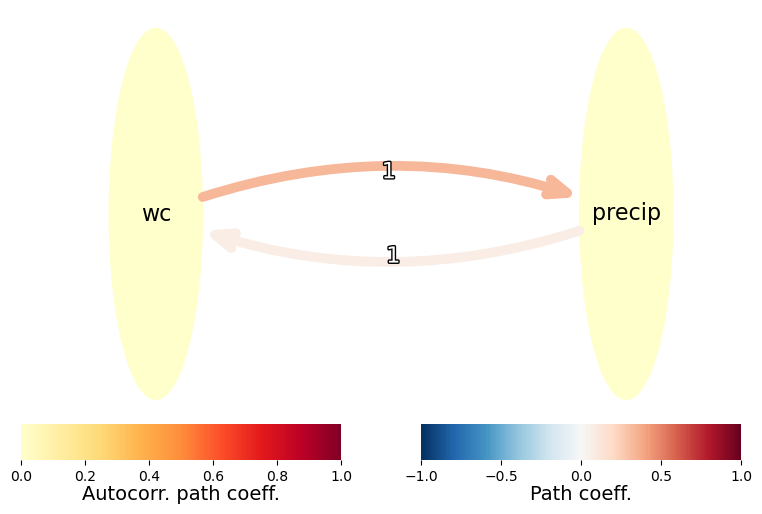

In [24]:
# Plot causal effect network and save it to a png format
ca.plot_cens_graph(val_matrix, link_matrix, save=True)

#### Apply bootstrapping to estimate the statisical robustness of the causal links